In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
while 'notebooks' in os.getcwd():
    os.chdir("..")

import torch
from transformers import AutoModelForImageClassification, AutoProcessor, AutoModel
from datasets import load_dataset
from src.attention_rollout import AttentionRollout
from src.gradient_rollout import AttentionGradRollout
from src.raw_attention import RawAttention
from src.influence import Influence
from torch.utils.data import DataLoader, RandomSampler
from tqdm import tqdm
import seaborn as sns
import numpy as np
import pandas as pd
import wordcloud
from src.text_utils import remove_stopwords, remove_punctuation, get_word_frequencies, lemmatize_text
from copy import deepcopy
from IPython.display import clear_output
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex'])
from src.perturbation import perturb_image

[nltk_data] Downloading package punkt to
[nltk_data]     /users/eleves-a/2022/pedro.silva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /users/eleves-a/2022/pedro.silva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /users/eleves-a/2022/pedro.silva/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /users/eleves-a/2022/pedro.silva/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /users/eleves-a/2022/pedro.silva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /users/eleves-a/2022/pedro.silva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!

In [3]:
device = 'cuda'

In [4]:
train_dataset = load_dataset("zh-plus/tiny-imagenet", cache_dir='/Data', split = 'train')\
    .train_test_split(test_size=1000, train_size=1000, seed=1)

# test_dataset = load_dataset("zh-plus/tiny-imagenet", cache_dir='/Data', split = 'test')

In [5]:
n_classes = len(np.bincount(train_dataset['train']['label']))

In [6]:
label_names = {
    0 : "World",
    1 : "Sports",
    2 : "Business",
    3 : "Sci/Tech"
}

In [7]:
model = AutoModelForImageClassification.from_pretrained(
    "tzhao3/vit-tiny-imagenet", 
    attn_implementation = 'eager', 
    cache_dir = '/Data'
)\
    .to(device)
processor = AutoProcessor.from_pretrained("tzhao3/vit-tiny-imagenet")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [8]:
batch_size = 1
train_dataloader = DataLoader(train_dataset['train'], batch_size=batch_size)
val_dataloader = DataLoader(train_dataset['test'], batch_size=batch_size)

## Raw attention Scores

In [9]:
metric = RawAttention(model, attention_layer_name='attention')

In [10]:

accs = {}

ks = np.arange(0, 1., 0.1)

for k in ks:
    y_pred_test = torch.Tensor([])
    y_true_test = torch.Tensor([])
    for row in tqdm(train_dataset['train']):
        try:
            tokens = processor(
                row['image'], 
                return_tensors='pt',
                padding = 'longest'
            )
        except:
            continue
        out, attn_matrix = metric(layer_idx= 0, **tokens.to(device))

        new_input = perturb_image(tokens['pixel_values'], attn_matrix.squeeze(), k, most_important=False)
        # print(new_input['input_ids'].shape)
        tokens['pixel_values'] = new_input

        with torch.no_grad():
            out = model(**tokens.to(device))

        y_pred = out.logits.topk(k = 5).indices
        correct = torch.Tensor([int(row['label'] in y_pred)])

        y_pred_test = torch.concat([y_pred_test, correct])


    accs[k] = y_pred_test.mean().item()

    print(f"Removed {k} best tokens. Accuracy = {accs[k]}")

  0%|          | 0/1000 [00:00<?, ?it/s]

/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
100%|██████████| 1000/1000 [00:14<00:00, 67.12it/s]


Removed 0.0 best tokens. Accuracy = 0.9622833728790283


100%|██████████| 1000/1000 [00:15<00:00, 63.06it/s]


Removed 0.1 best tokens. Accuracy = 0.9561671614646912


100%|██████████| 1000/1000 [00:16<00:00, 59.51it/s]


Removed 0.2 best tokens. Accuracy = 0.9429153800010681


100%|██████████| 1000/1000 [00:17<00:00, 57.08it/s]


Removed 0.30000000000000004 best tokens. Accuracy = 0.9204893112182617


100%|██████████| 1000/1000 [00:18<00:00, 54.53it/s]


Removed 0.4 best tokens. Accuracy = 0.8735983967781067


100%|██████████| 1000/1000 [00:19<00:00, 51.89it/s]


Removed 0.5 best tokens. Accuracy = 0.8154944181442261


100%|██████████| 1000/1000 [00:20<00:00, 49.64it/s]


Removed 0.6000000000000001 best tokens. Accuracy = 0.7115188837051392


100%|██████████| 1000/1000 [00:20<00:00, 48.40it/s]


Removed 0.7000000000000001 best tokens. Accuracy = 0.5453618764877319


100%|██████████| 1000/1000 [00:21<00:00, 46.75it/s]


Removed 0.8 best tokens. Accuracy = 0.37003058195114136


100%|██████████| 1000/1000 [00:22<00:00, 44.90it/s]

Removed 0.9 best tokens. Accuracy = 0.1845056116580963


In [11]:
pd.Series(accs)\
    .to_pickle("data/results/vit_raw_attention0_perturbation_negative.pkl")

# Attention Rollout

In [12]:
metric = AttentionRollout(model, attention_layer_name='attention')

In [13]:

accs = {}

ks = np.arange(0, 1., 0.1)

for k in ks:
    y_pred_test = torch.Tensor([])
    y_true_test = torch.Tensor([])
    for row in tqdm(train_dataset['train']):
        try:
            tokens = processor(
                row['image'], 
                return_tensors='pt',
                padding = 'longest'
            )
        except:
            continue
        out, attn_matrix = metric(**tokens.to(device))

        new_input = perturb_image(tokens['pixel_values'], attn_matrix.squeeze(), k, most_important=False)
        # print(new_input['input_ids'].shape)
        tokens['pixel_values'] = new_input

        with torch.no_grad():
            out = model(**tokens.to(device))

        y_pred = out.logits.topk(k = 5).indices
        correct = torch.Tensor([int(row['label'] in y_pred)])

        y_pred_test = torch.concat([y_pred_test, correct])


    accs[k] = y_pred_test.mean().item()

    print(f"Removed {k} worst tokens. Accuracy = {accs[k]}")

  0%|          | 0/1000 [00:00<?, ?it/s]

/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
100%|██████████| 1000/1000 [01:07<00:00, 14.88it/s]


Removed 0.0 worst tokens. Accuracy = 0.9622833728790283


100%|██████████| 1000/1000 [01:07<00:00, 14.74it/s]


Removed 0.1 worst tokens. Accuracy = 0.9592252969741821


100%|██████████| 1000/1000 [01:14<00:00, 13.47it/s]


Removed 0.2 worst tokens. Accuracy = 0.9439347386360168


100%|██████████| 1000/1000 [01:17<00:00, 12.85it/s]


Removed 0.30000000000000004 worst tokens. Accuracy = 0.9266055226325989


100%|██████████| 1000/1000 [01:19<00:00, 12.55it/s]


Removed 0.4 worst tokens. Accuracy = 0.8950051069259644


100%|██████████| 1000/1000 [01:22<00:00, 12.18it/s]


Removed 0.5 worst tokens. Accuracy = 0.8348624110221863


100%|██████████| 1000/1000 [01:23<00:00, 11.99it/s]


Removed 0.6000000000000001 worst tokens. Accuracy = 0.7400611639022827


100%|██████████| 1000/1000 [01:19<00:00, 12.63it/s]


Removed 0.7000000000000001 worst tokens. Accuracy = 0.5861365795135498


100%|██████████| 1000/1000 [01:14<00:00, 13.38it/s]


Removed 0.8 worst tokens. Accuracy = 0.4209989905357361


100%|██████████| 1000/1000 [01:16<00:00, 13.06it/s]

Removed 0.9 worst tokens. Accuracy = 0.2181447446346283


In [14]:
pd.Series(accs)\
    .to_pickle("data/results/vit_attn_rollout_perturbation_negative.pkl")

## Gradient attention rollout

In [15]:
metric = AttentionGradRollout(model, attention_layer_name='attention.dropout')

In [16]:
attn_matrix.shape

torch.Size([1, 197, 197])

In [17]:

accs = {}

ks = np.arange(0, 1., 0.1)

for k in ks:
    y_pred_test = torch.Tensor([])
    y_true_test = torch.Tensor([])
    for row in tqdm(train_dataset['train']):
        try:
            tokens = processor(
                row['image'], 
                return_tensors='pt',
                padding = 'longest'
            )
            tokens['labels'] = torch.tensor(row['label'])
        except:
            continue
        out, attn_matrix = metric(**tokens.to(device))

        new_input = perturb_image(tokens['pixel_values'], attn_matrix.squeeze(), k, most_important=False)
        # print(new_input['input_ids'].shape)
        tokens['pixel_values'] = new_input

        with torch.no_grad():
            out = model(**tokens.to(device))

        y_pred = out.logits.topk(k = 5).indices
        correct = torch.Tensor([int(row['label'] in y_pred)])

        y_pred_test = torch.concat([y_pred_test, correct])


    accs[k] = y_pred_test.mean().item()

    print(f"Removed {k} worst tokens. Accuracy = {accs[k]}")

  0%|          | 0/1000 [00:00<?, ?it/s]

/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
100%|██████████| 1000/1000 [01:07<00:00, 14.77it/s]


Removed 0.0 worst tokens. Accuracy = 0.9622833728790283


100%|██████████| 1000/1000 [01:08<00:00, 14.56it/s]


Removed 0.1 worst tokens. Accuracy = 0.9612640142440796


100%|██████████| 1000/1000 [01:02<00:00, 16.04it/s]


Removed 0.2 worst tokens. Accuracy = 0.9480122327804565


100%|██████████| 1000/1000 [01:02<00:00, 16.05it/s]


Removed 0.30000000000000004 worst tokens. Accuracy = 0.9357798099517822


100%|██████████| 1000/1000 [01:03<00:00, 15.86it/s]


Removed 0.4 worst tokens. Accuracy = 0.9143730998039246


100%|██████████| 1000/1000 [01:03<00:00, 15.63it/s]


Removed 0.5 worst tokens. Accuracy = 0.8756371140480042


100%|██████████| 1000/1000 [01:04<00:00, 15.43it/s]


Removed 0.6000000000000001 worst tokens. Accuracy = 0.8012232184410095


100%|██████████| 1000/1000 [01:05<00:00, 15.25it/s]


Removed 0.7000000000000001 worst tokens. Accuracy = 0.6911314725875854


100%|██████████| 1000/1000 [01:06<00:00, 15.05it/s]


Removed 0.8 worst tokens. Accuracy = 0.49133536219596863


100%|██████████| 1000/1000 [01:07<00:00, 14.84it/s]

Removed 0.9 worst tokens. Accuracy = 0.21712538599967957


In [18]:
pd.Series(accs)\
    .to_pickle("data/results/vit_grad_rollout_perturbation_negative.pkl")

## Influence 

In [19]:
metric = Influence(model, discard_ratio=0.9, is_vit=True, return_mask=False)

In [20]:
attn_matrix.shape

torch.Size([1, 197, 197])

In [21]:

accs = {}

ks = np.arange(0, 1., 0.1)

for k in ks:
    y_pred_test = torch.Tensor([])
    y_true_test = torch.Tensor([])
    for row in tqdm(train_dataset['train']):
        try:
            tokens = processor(
                row['image'], 
                return_tensors='pt',
                padding = 'longest'
            )
        except:
            continue

        attn_matrix = metric(**tokens.to(device))

        new_input = perturb_image(tokens['pixel_values'], attn_matrix.squeeze(), k, most_important=False)
        # print(new_input['input_ids'].shape)
        tokens['pixel_values'] = new_input

        with torch.no_grad():
            out = model(**tokens.to(device))

        y_pred = out.logits.topk(k = 5).indices
        correct = torch.Tensor([int(row['label'] in y_pred)])

        y_pred_test = torch.concat([y_pred_test, correct])


    accs[k] = y_pred_test.mean().item()

    print(f"Removed {k} worst tokens. Accuracy = {accs[k]}")

  0%|          | 0/1000 [00:00<?, ?it/s]

/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
100%|██████████| 1000/1000 [00:45<00:00, 21.95it/s]


Removed 0.0 worst tokens. Accuracy = 0.9622833728790283


100%|██████████| 1000/1000 [00:46<00:00, 21.51it/s]


Removed 0.1 worst tokens. Accuracy = 0.9541284441947937


100%|██████████| 1000/1000 [00:47<00:00, 21.12it/s]


Removed 0.2 worst tokens. Accuracy = 0.9429153800010681


100%|██████████| 1000/1000 [00:48<00:00, 20.76it/s]


Removed 0.30000000000000004 worst tokens. Accuracy = 0.9266055226325989


100%|██████████| 1000/1000 [00:49<00:00, 20.34it/s]


Removed 0.4 worst tokens. Accuracy = 0.903160035610199


100%|██████████| 1000/1000 [00:50<00:00, 19.96it/s]


Removed 0.5 worst tokens. Accuracy = 0.8715596199035645


100%|██████████| 1000/1000 [00:50<00:00, 19.63it/s]


Removed 0.6000000000000001 worst tokens. Accuracy = 0.8053007125854492


100%|██████████| 1000/1000 [00:51<00:00, 19.38it/s]


Removed 0.7000000000000001 worst tokens. Accuracy = 0.6860346794128418


100%|██████████| 1000/1000 [00:52<00:00, 18.95it/s]


Removed 0.8 worst tokens. Accuracy = 0.4872578978538513


100%|██████████| 1000/1000 [00:53<00:00, 18.54it/s]

Removed 0.9 worst tokens. Accuracy = 0.20183485746383667


In [22]:
pd.Series(accs)\
    .to_pickle("data/results/vit_influence_perturbation_negative.pkl")

## Final plot

raw_attention0 - AUC = 0.6708970502018929
attn_rollout - AUC = 0.6897043868899346
influence - AUC = 0.7159021407365801
grad_rollout - AUC = 0.7208460703492164


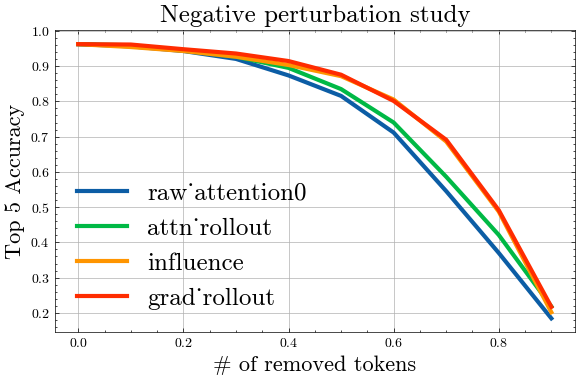

In [23]:
metrics = ['raw_attention0', 'attn_rollout','influence', 'grad_rollout', ]

plt.figure(figsize=(6,4))
for metric in metrics:
    x = pd.read_pickle(f"data/results/vit_{metric}_perturbation_negative.pkl")
    auc = np.trapz(x.values, x.index)

    print(f"{metric} - AUC = {auc}")
    plt.plot(x, label = metric, linewidth = 3)

plt.grid()
plt.title("Negative perturbation study", fontsize = 18)
plt.ylabel("Top 5 Accuracy", fontsize = 16)
plt.xlabel("# of removed tokens", fontsize = 16)
plt.legend(fontsize = 18)
plt.tight_layout()